In [3]:
# Code used in part 1 of How I used machine learning to classify emails and turn them into insights.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD 
from sklearn.preprocessing import normalize 

from helpers import * 

%matplotlib inline

In [4]:
emails = pd.read_csv('split_emails.csv')

# Lets create a new frame with the data we need.
email_df = pd.DataFrame(parse_into_emails(emails.message))

# Drop emails with empty body, to or from_ columns. 
email_df.drop(email_df.query("body == '' | to == '' | from_ == ''").index, inplace=True)

In [5]:
# Flag email as important if the title start with re, fw or fwd
email_df.loc[:, 'isImportant'] = email_df.subject.str.lower().str.split(':').apply(lambda x:x[0] in ['re', 'fw', 'fwd'])

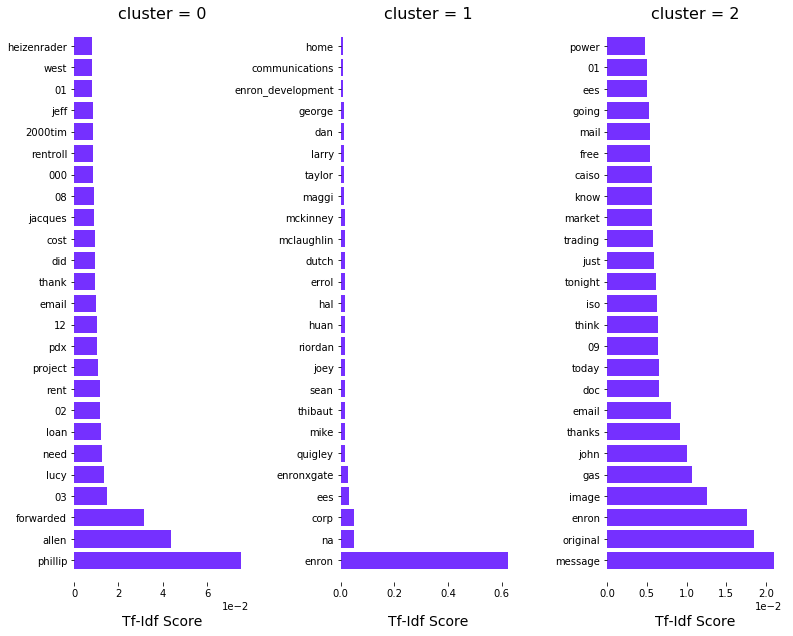

In [6]:
# print len(email_data.from_.unique()) # 1222 unique email addresses
# print len(email_data.to.unique())  # 1593 unique email addresses
# print email_df.head()

# At this stage we are sure we have sanitized all the data we need. 
# print email_data.shape # (9464, 4)

# At this point we are going to tokenize the bodies and convert them
# into a document-term matrix.

# Some note on min_df and max_df
# max_df=0.5 means "ignore all terms that appear in more then 50% of the documents"
# min_df=2 means "ignore all terms that appear in less then 2 documents"
stopwords = ENGLISH_STOP_WORDS.union(['ect', 'hou', 'com', 'recipient'])
vect = TfidfVectorizer(analyzer='word', stop_words=stopwords, max_df=0.3, min_df=2)

X = vect.fit_transform(email_df.body)
features = vect.get_feature_names()

# Let's print the top 10 terms in document 1
#print top_feats_in_doc(X, features, 1, 10)

# Now we print the top terms across all documents.
#print top_mean_feats(X, features, None, 0.1, 10) 

# As clustering algorithm KMeams is a perfect fit.
n_clusters = 3
clf = KMeans(n_clusters=n_clusters, 
            max_iter=100, 
            init='k-means++', 
            n_init=1)
labels = clf.fit_predict(X)

# For larger datasets use mini-batch KMeans, so we dont have to read all data into memory.
# batch_size = 500
# clf = MiniBatchKMeans(n_clusters=n_clusters, init_size=1000, batch_size=batch_size, max_iter=100)  
# clf.fit(X)

# Let's plot this with matplotlib to visualize it.
# First we need to make 2D coordinates from the sparse matrix.
X_dense = X.todense()
pca = PCA(n_components=2).fit(X_dense)
coords = pca.transform(X_dense)

# Lets plot it again, but this time we add some color to it.
# This array needs to be at least the length of the n_clusters.
label_colors = ["#2AB0E9", "#2BAF74", "#D7665E", "#CCCCCC", 
                "#D2CA0D", "#522A64", "#A3DB05", "#FC6514"]
colors = [label_colors[i] for i in labels]

#plt.scatter(coords[:, 0], coords[:, 1], c=colors)
# Plot the cluster centers
centroids = clf.cluster_centers_
centroid_coords = pca.transform(centroids)
# plt.scatter(centroid_coords[:, 0], centroid_coords[:, 1], marker='X', s=200, linewidths=2, c='#444d60')
# plt.show()

#Use this to print the top terms per cluster with matplotlib.
plot_tfidf_classfeats_h(top_feats_per_cluster(X, labels, features, 0.1, 25))

In [7]:
from sklearn.metrics.pairwise import linear_kernel
from query import EmailDataset

# print out the vector of the first email
# print(vec_train[0:1])

vec_train = X

# Find cosine similarity between the first email and all others.
cosine_sim = linear_kernel(vec_train[0:1], vec_train).flatten()
# print out the cosine similarities
# print(cosine_sim)

# Finding emails related to a query.
query = "john"

# Transform the query into the original vector
vec_query = vect.transform([query])

cosine_sim = linear_kernel(vec_query, vec_train).flatten()

# Find top 10 most related emails to the query.
related_email_indices = cosine_sim.argsort()[:-10:-1]
# print out the indices of the 10 most related emails.
# print(related_email_indices)

# print out the first email 
first_email_index = related_email_indices[0]

# use the EmailDataset class to query for keywords.
# ds = EmailDataset()
# results = ds.query('salary', 10)

# Print out the first result.
# print(ds.find_email_by_index(results[0]))

In [8]:
email_df["folder"] = emails.file.str.split('/').apply(lambda x: '/'.join(x[:-1]) if type(x)==list and len(x) else None)
email_df["user"] = email_df.folder.str.split('/').apply(lambda x:x[0] if type(x)==list and len(x) else None)

In [9]:
# users in dataset
print(email_df.user.unique())

['allen-p' 'arnold-j' 'arora-h' 'badeer-r' 'bailey-s' 'bass-e']


In [10]:
# number of folders for each users
email_df.groupby('user').apply(lambda x:x.folder.unique().shape[0])

user
allen-p      9
arnold-j    44
arora-h     14
badeer-r    15
bailey-s     5
bass-e       1
dtype: int64

In [11]:
check = email_df.copy()
reorder = np.arange(check.shape[0])
np.random.shuffle(reorder)
check = check.reindex(reorder).reset_index().drop(['index'], axis=1)
train, test = check.iloc[:9000], check.iloc[9000:]
X_dense_reorder = X_dense[reorder, :]

In [12]:
class distance_email_classifier_single_linkage(object):
    def __init__(self, train_set, X):
        self.train_set = train_set
        self.X = X
    
    def predict(self, email, vec):
        distance =  self.train_set.loc[self.train_set.user == email.user, :].groupby('folder').\
                apply(lambda x: np.max(linear_kernel(vec, X_dense_reorder[x.index,:]).flatten()))
        order = distance.rank(ascending=False)
        return (email.folder, order.loc[email.folder] if email.folder in order else None,
                            order.loc[order==order.min()].index[0], order.shape[0])
    
class distance_email_classifier_complete_linkage(object):
    def __init__(self, train_set, X):
        self.train_set = train_set
        self.X = X
    
    def predict(self, email, vec):
        distance =  self.train_set.loc[self.train_set.user == email.user, :].groupby('folder').\
                apply(lambda x: np.min(linear_kernel(vec, X_dense_reorder[x.index,:]).flatten()))
        order = distance.rank(ascending=False)
        return (email.folder, order.loc[email.folder] if email.folder in order else None,
                            order.loc[order==order.min()].index[0], order.shape[0])

class distance_email_classifier_average_linkage(object):
    def __init__(self, train_set, X):
        self.train_set = train_set
        self.X = X
    
    def predict(self, email, vec):
        distance =  self.train_set.loc[self.train_set.user == email.user, :].groupby('folder').\
                apply(lambda x: np.mean(linear_kernel(vec, X_dense_reorder[x.index,:]).flatten()))
        order = distance.rank(ascending=False)
        return (email.folder, order.loc[email.folder] if email.folder in order else None,
                            order.loc[order==order.min()].index[0], order.shape[0])

In [13]:
dec_single = distance_email_classifier_single_linkage(train, X_dense_reorder)
dec_complete = distance_email_classifier_complete_linkage(train, X_dense_reorder)
dec_average = distance_email_classifier_average_linkage(train, X_dense_reorder)

In [14]:
test = test.dropna()

In [ ]:
count = 0
for i in range(test.shape[0]):
    if (test.iloc[i].folder == dec_single.predict(test.iloc[i], X_dense_reorder[test.index[i], :])[2]):
        count += 1
    print(i, dec_single.predict(test.iloc[i], X_dense_reorder[test.index[i], :]))
print(count/test.shape[0])

0 ('allen-p/sent_items', 5.0, 'allen-p/all_documents', 9)
1 ('badeer-r/press_releases', 10.0, 'badeer-r/sent_items', 15)
2 ('allen-p/sent', 4.0, 'allen-p/_sent_mail', 9)
3 ('allen-p/_sent_mail', 4.5, 'allen-p/all_documents', 9)
4 ('arnold-j/all_documents', 3.5, 'arnold-j/_sent_mail', 43)
5 ('badeer-r/discussion_threads', 2.0, 'badeer-r/california', 15)
6 ('arnold-j/inbox', 4.0, 'arnold-j/_sent_mail', 43)
7 ('arnold-j/deleted_items', 2.0, 'arnold-j/sent', 43)
8 ('arnold-j/_sent_mail', 4.5, 'arnold-j/all_documents', 43)
9 ('arnold-j/sent', 3.0, 'arnold-j/_sent_mail', 43)
10 ('arnold-j/all_documents', 3.0, 'arnold-j/_sent_mail', 43)
11 ('allen-p/deleted_items', 8.0, 'allen-p/all_documents', 9)
12 ('arnold-j/all_documents', 2.0, 'arnold-j/discussion_threads', 43)
13 ('allen-p/_sent_mail', 3.5, 'allen-p/all_documents', 9)
14 ('arnold-j/discussion_threads', 6.0, 'arnold-j/sent', 43)
15 ('allen-p/_sent_mail', 4.0, 'allen-p/all_documents', 9)
16 ('allen-p/_sent_mail', 4.0, 'allen-p/all_documen

136 ('arnold-j/deleted_items', 1.0, 'arnold-j/deleted_items', 43)
137 ('arnold-j/sent_items', 4.5, 'arnold-j/_sent_mail', 43)
138 ('arnold-j/all_documents', 4.5, 'arnold-j/_sent_mail', 43)
139 ('arora-h/inbox', 9.5, 'arora-h/inbox/saved_mail', 14)
140 ('badeer-r/notes_inbox', 1.0, 'badeer-r/notes_inbox', 15)
141 ('arnold-j/sent_items', 2.0, 'arnold-j/discussion_threads', 43)
142 ('arnold-j/personal', 18.0, 'arnold-j/purchasing', 43)
143 ('arnold-j/_sent_mail', 1.5, 'arnold-j/_sent_mail', 43)
144 ('arnold-j/_sent_mail', 3.5, 'arnold-j/all_documents', 43)
145 ('allen-p/all_documents', 3.0, 'allen-p/_sent_mail', 9)
146 ('allen-p/discussion_threads', 3.5, 'allen-p/all_documents', 9)
147 ('arnold-j/_sent_mail', 2.5, 'arnold-j/_sent_mail', 43)
148 ('arnold-j/_sent_mail', 3.5, 'arnold-j/all_documents', 43)
149 ('arnold-j/deleted_items', 5.0, 'arnold-j/_sent_mail', 43)
150 ('arnold-j/all_documents', 4.5, 'arnold-j/_sent_mail', 43)
151 ('allen-p/sent', 4.5, 'allen-p/_sent_mail', 9)
152 ('allen-

272 ('arnold-j/requisite', 1.0, 'arnold-j/requisite', 43)
273 ('arora-h/inbox', 3.0, 'arora-h/deleted_items', 14)
274 ('arnold-j/deleted_items', 1.0, 'arnold-j/deleted_items', 43)
275 ('arnold-j/universal_studios', 12.0, 'arnold-j/vulcan_signs', 43)
276 ('badeer-r/discussion_threads', 2.0, 'badeer-r/capx', 15)
277 ('allen-p/deleted_items', 6.0, 'allen-p/_sent_mail', 9)
278 ('allen-p/_sent_mail', 8.0, 'allen-p/all_documents', 9)
279 ('arora-h/all_documents', 1.0, 'arora-h/all_documents', 14)
280 ('allen-p/all_documents', 2.5, 'allen-p/_sent_mail', 9)
281 ('badeer-r/notes_inbox', 2.0, 'badeer-r/dj_articles', 15)
282 ('allen-p/sent_items', 6.0, 'allen-p/_sent_mail', 9)
283 ('allen-p/all_documents', 4.5, 'allen-p/_sent_mail', 9)
284 ('arnold-j/sent_items', 5.0, 'arnold-j/active_international', 43)
285 ('arnold-j/all_documents', 3.0, 'arnold-j/sent_items', 43)
286 ('arnold-j/sent', 2.5, 'arnold-j/_sent_mail', 43)
287 ('allen-p/discussion_threads', 1.0, 'allen-p/discussion_threads', 9)
288 (

407 ('allen-p/sent', 1.0, 'allen-p/sent', 9)
408 ('allen-p/_sent_mail', 3.5, 'allen-p/all_documents', 9)
409 ('allen-p/_sent_mail', 4.5, 'allen-p/all_documents', 9)
410 ('badeer-r/discussion_threads', 1.0, 'badeer-r/discussion_threads', 15)
411 ('arnold-j/all_documents', 3.5, 'arnold-j/deleted_items', 43)
412 ('allen-p/sent_items', 2.0, 'allen-p/_sent_mail', 9)
413 ('arnold-j/all_documents', 4.0, 'arnold-j/_sent_mail', 43)
414 ('allen-p/_sent_mail', 6.0, 'allen-p/all_documents', 9)
415 ('arnold-j/deleted_items', 3.0, 'arnold-j/all_documents', 43)
416 ('badeer-r/all_documents', 1.0, 'badeer-r/all_documents', 15)
417 ('allen-p/_sent_mail', 4.5, 'allen-p/all_documents', 9)
418 ('arnold-j/sent', 1.0, 'arnold-j/sent', 43)
419 ('allen-p/sent', 4.0, 'allen-p/_sent_mail', 9)
420 ('allen-p/all_documents', 4.0, 'allen-p/_sent_mail', 9)
421 ('arnold-j/all_documents', 1.0, 'arnold-j/all_documents', 43)
422 ('allen-p/sent', 6.0, 'allen-p/_sent_mail', 9)
423 ('arnold-j/all_documents', 5.0, 'arnold-j

In [ ]:
count = 0
for i in range(test.shape[0]):
    if (test.iloc[i].folder == dec_complete.predict(test.iloc[i], X_dense_reorder[test.index[i], :])[2]):
        count += 1
    print(i, dec_complete.predict(test.iloc[i], X_dense_reorder[test.index[i], :]))
print(count/test.shape[0])

0 ('allen-p/sent_items', 5.0, 'allen-p/_sent_mail', 9)
1 ('badeer-r/press_releases', 11.5, 'badeer-r/dj_articles', 15)
2 ('allen-p/sent', 5.0, 'allen-p/_sent_mail', 9)
3 ('allen-p/_sent_mail', 5.0, 'allen-p/_sent_mail', 9)
4 ('arnold-j/all_documents', 22.5, 'arnold-j/computer_associates', 43)
5 ('badeer-r/discussion_threads', 9.5, 'badeer-r/move', 15)
6 ('arnold-j/inbox', 28.5, 'arnold-j/human_resources', 43)
7 ('arnold-j/deleted_items', 34.5, 'arnold-j/sonoco', 43)
8 ('arnold-j/_sent_mail', 29.0, 'arnold-j/nepco', 43)
9 ('arnold-j/sent', 34.5, 'arnold-j/corestaff', 43)
10 ('arnold-j/all_documents', 34.0, 'arnold-j/sap', 43)
11 ('allen-p/deleted_items', 5.0, 'allen-p/_sent_mail', 9)
12 ('arnold-j/all_documents', 25.5, 'arnold-j/sonoco', 43)
13 ('allen-p/_sent_mail', 5.0, 'allen-p/_sent_mail', 9)
14 ('arnold-j/discussion_threads', 26.0, 'arnold-j/sarah_joy_hunter', 43)
15 ('allen-p/_sent_mail', 5.0, 'allen-p/_sent_mail', 9)
16 ('allen-p/_sent_mail', 5.0, 'allen-p/_sent_mail', 9)
17 ('ar

In [ ]:
count = 0
for i in range(test.shape[0]):
    if (test.iloc[i].folder == dec_average.predict(test.iloc[i], X_dense_reorder[test.index[i], :])[2]):
        count += 1
    print(i, dec_average.predict(test.iloc[i], X_dense_reorder[test.index[i], :]))
print(count/test.shape[0])

In [268]:
print(emails.loc[2, 'message'])

Message-ID: <24216240.1075855687451.JavaMail.evans@thyme>
Date: Wed, 18 Oct 2000 03:00:00 -0700 (PDT)
From: phillip.allen@enron.com
To: leah.arsdall@enron.com
Subject: Re: test
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Leah Van Arsdall
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Dec2000\Notes Folders\'sent mail
X-Origin: Allen-P
X-FileName: pallen.nsf

test successful.  way to go!!!
